<a href="https://colab.research.google.com/github/sahilsoni18/edyoda_assignment_1_operator/blob/main/Emp_Tunrover_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
roc_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings('ignore')

In [33]:
path = "HR_comma_sep.csv"
df = pd.read_csv(path)

In [34]:
print("Shape:", df.shape)
df.head()

Shape: (14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [35]:
# Check missing values
df.isnull().sum()

,0
satisfaction_level,0
last_evaluation,0
number_project,0
average_montly_hours,0
time_spend_company,0
Work_accident,0
left,0
promotion_last_5years,0
sales,0
salary,0


In [36]:
# Check duplicates
df.duplicated().sum()

np.int64(3008)

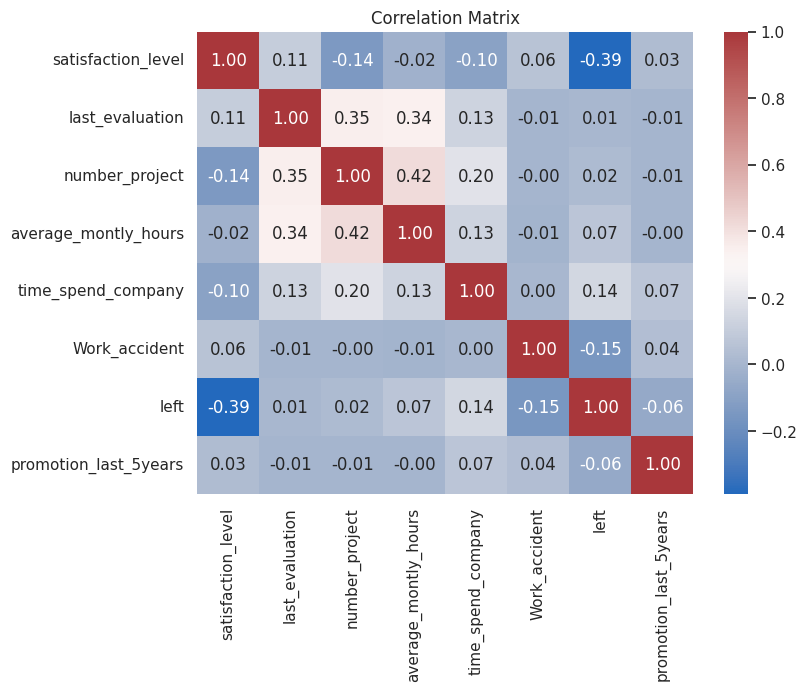

In [38]:
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation Matrix")
plt.show()

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

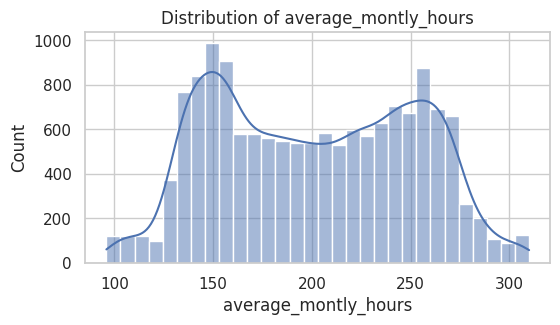

In [39]:
# Distribution plots
for col in ["satisfaction_level", "last_evaluation", "average_montly_hours"]:
  plt.figure(figsize=(6,3))
sns.histplot(df[col], kde=True)
plt.title(f"Distribution of {col}")
plt.show()

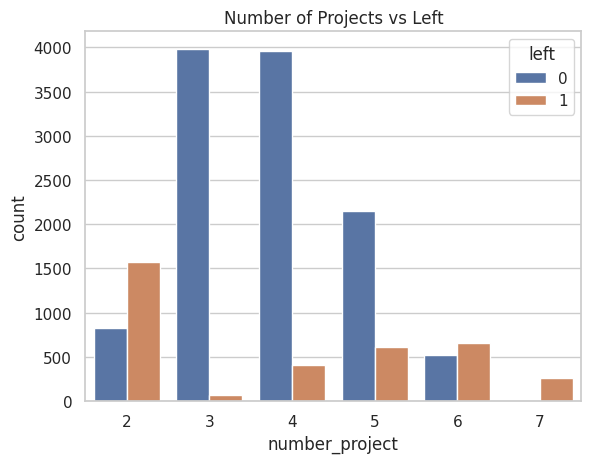

In [40]:
# Project counts by turnover
sns.countplot(x="number_project", hue="left", data=df)
plt.title("Number of Projects vs Left")
plt.show()

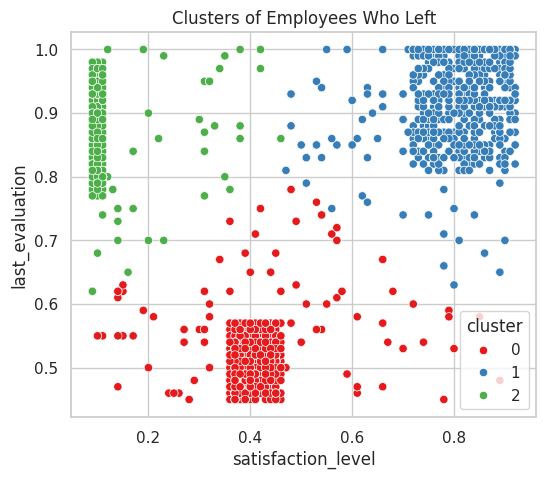

,satisfaction_level,last_evaluation
cluster,,
0,0.412304,0.517265
1,0.808031,0.916415
2,0.111321,0.870884


In [41]:
left_df = df[df['left']==1][['satisfaction_level','last_evaluation']]
scaler = StandardScaler()
X_cluster = scaler.fit_transform(left_df)


kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_cluster)
left_df['cluster'] = labels


plt.figure(figsize=(6,5))
sns.scatterplot(x='satisfaction_level', y='last_evaluation', hue='cluster', data=left_df, palette='Set1')
plt.title("Clusters of Employees Who Left")
plt.show()


left_df.groupby('cluster').mean()

In [42]:
# One-hot encode categorical
X = pd.get_dummies(df.drop('left', axis=1), drop_first=True)
y = df['left']

In [43]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=123)


# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))

Before SMOTE: [9142 2857]
After SMOTE: [9142 9142]



GradientBoosting Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2286
           1       0.94      0.93      0.93       714

    accuracy                           0.97      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.97      0.97      0.97      3000

Confusion Matrix:
 [[2240   46]
 [  47  667]]


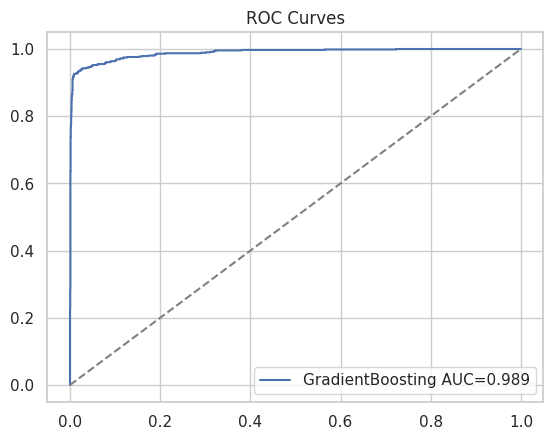

,GradientBoosting
roc_auc,0.988773
pr_auc,0.975017


In [44]:
scaler_final = StandardScaler()
X_train_res_scaled = scaler_final.fit_transform(X_train_res)
X_test_scaled = scaler_final.transform(X_test)


models = {
"LogisticRegression": LogisticRegression(max_iter=1000, solver='liblinear'),
"RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
"GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}


results = {}
for name, model in models.items():
  model.fit(X_train_res_scaled, y_train_res)
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:,1]
print(f"\n{name} Classification Report:\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
results[name] = {"roc_auc": roc_auc, "pr_auc": pr_auc}
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"{name} AUC={roc_auc:.3f}")


plt.plot([0,1],[0,1],'--',color='grey')
plt.legend()
plt.title("ROC Curves")
plt.show()


pd.DataFrame(results)

In [45]:
best_model = max(results.items(), key=lambda kv: kv[1]['pr_auc'])[0]
print("Best model by PR-AUC:", best_model)


Best model by PR-AUC: GradientBoosting


In [46]:
model = models[best_model]
y_proba_test = model.predict_proba(X_test_scaled)[:, 1]

# Assign risk zones
def risk_zone(p):
    if p < 0.20:
        return 'Safe (Green)'
    elif p < 0.60:
        return 'Low-Risk (Yellow)'
    elif p < 0.90:
        return 'Medium-Risk (Orange)'
    else:
        return 'High-Risk (Red)'

zones = pd.Series(y_proba_test).apply(risk_zone)
zone_counts = zones.value_counts()
zone_counts

,count
Safe (Green),2131
High-Risk (Red),632
Low-Risk (Yellow),170
Medium-Risk (Orange),67


In [47]:
strategies = {
'Safe (Green)': 'Continue standard engagement. Monitor normally.',
'Low-Risk (Yellow)': 'Light engagement: surveys, recognition.',
'Medium-Risk (Orange)': 'Targeted intervention: training, workload balance.',
'High-Risk (Red)': 'Immediate action: retention package, stay interview.'
}
strategies

{'Safe (Green)': 'Continue standard engagement. Monitor normally.',
 'Low-Risk (Yellow)': 'Light engagement: surveys, recognition.',
 'Medium-Risk (Orange)': 'Targeted intervention: training, workload balance.',
 'High-Risk (Red)': 'Immediate action: retention package, stay interview.'}